# **Session 4: Time Series Classification**
This session focuses on the application of time series classification. It will go through the basics of working with time series data and the common neural architectures used in time series deep learning. The ultimate goal of the session is to create a classifier that can recognize spoken digits in Arabic.

## Resources

1. https://www.timeseriesclassification.com
2. https://danijar.com/tips-for-training-recurrent-neural-networks/#:~:text=We%20usually%20use%20adaptive%20optimizers,gradients%20that%20exceeds%20this%20range.
3. https://github.com/hfawaz/dl-4-tsc/tree/master

---

In [ ]:
%pip install sktime seaborn torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 16.8 MB/s eta 0:00:00


In [ ]:
# --- set up our imports for this session ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
import ipywidgets as widgets
import argparse
# --- torch imports ---
import torch
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

## **Recurrent Neural Networks**

Recurrent neural networks propagate results through an ordered sequence of inputs. They output hidden states, $h_t$, at each time step, $t$, in a sequence, which is then fed into the inputs of the next time step, $t+1$.

Therefore a recurrent layer can be posed as:

$h_t = f(h_{t-1}, x)$

For a linear single RNN layer the function becomes

$h_t = \phi (\theta_{hx} x_t + \theta_{hh} h_{t-1})$

where
- $x_t \in \Re^{d \times 1}$ input column vector at time step $t$
- $h_t \in \Re^{p \times 1}$ hidden column vector at time step $t$
- $h_{t-1} \in \Re^{p \times 1}$ hidden column vector at time step $t-1$ which can be initialized to zero.
- $\theta_{hx} \in \Re^{p \times d}$ input to hidden parameter matrix
- $\theta_{hh} \in \Re^{p \times p}$ hidden to hidden time transition parameter matrix
- $\phi = $ some activation function applied element-wise

An output layer can then be attached:

$y_t = \theta_{yh} h_t$

where
- $y_t \in \Re^{m \times 1}$ output column vector at time $t$
- $\theta_{yh} \in \Re^{m \times p}$ hidden to output parameter matrix

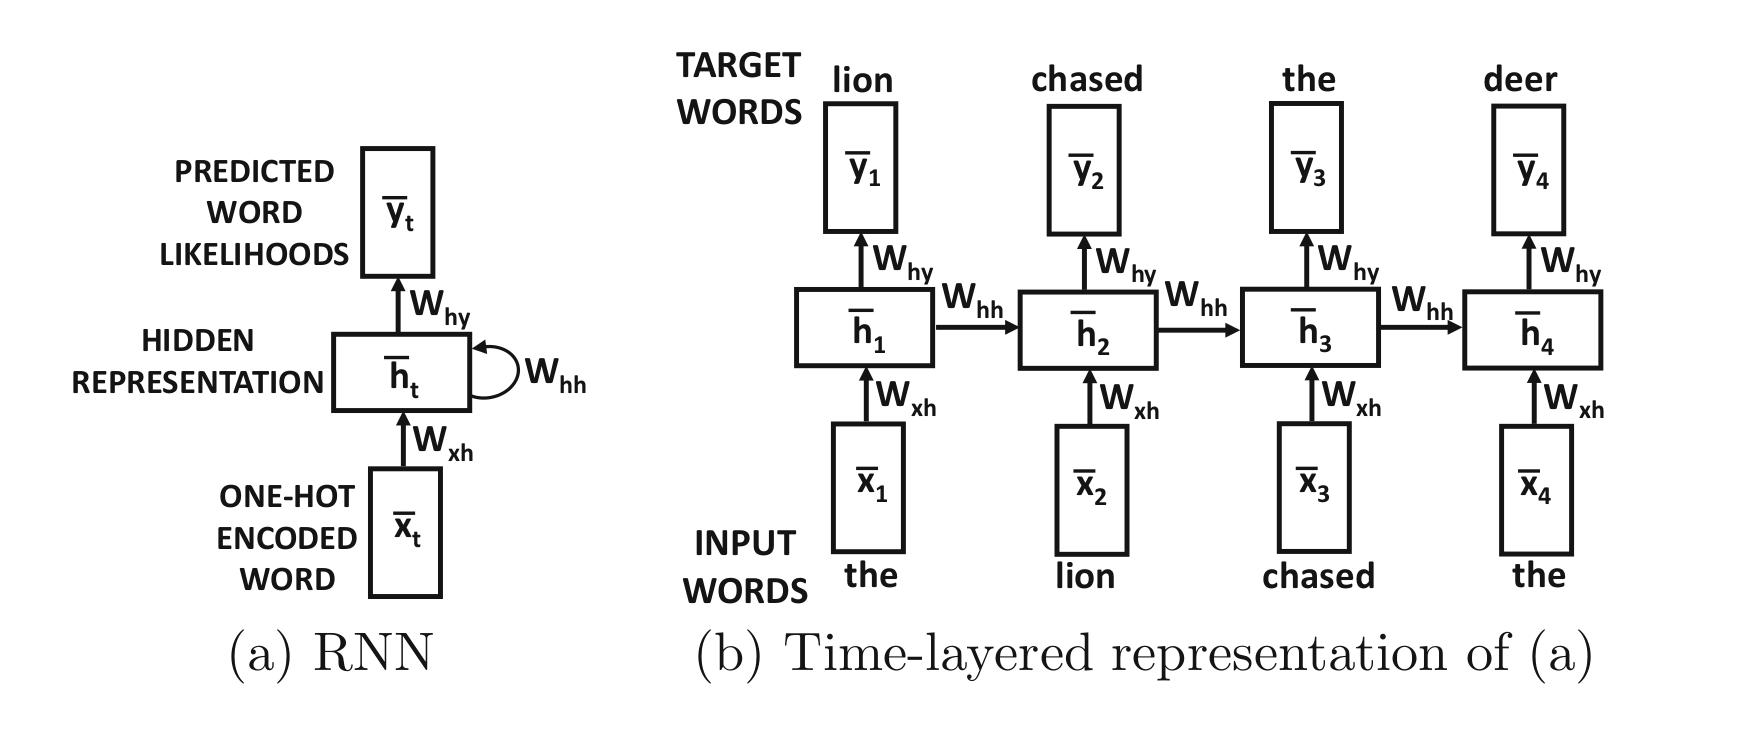

### **Challenges of Training Recurrent Networks**

The primary challenge of training RNNs is with the vanishing and exploding gradients. As the length of the sequence increases so do the number of time layers and the gradients multiply with each other.

#### *Layer Normalization*
Layer normalization helps reduce the effect of the vanishing and exploding gradients. Layer normalization is similar to batch normalization. Batch normalization normalizes each feature independently across the mini-batch. Layer normalization normalizes each of the inputs in the batch independently across all features.

See resource: https://www.pinecone.io/learn/batch-layer-normalization/

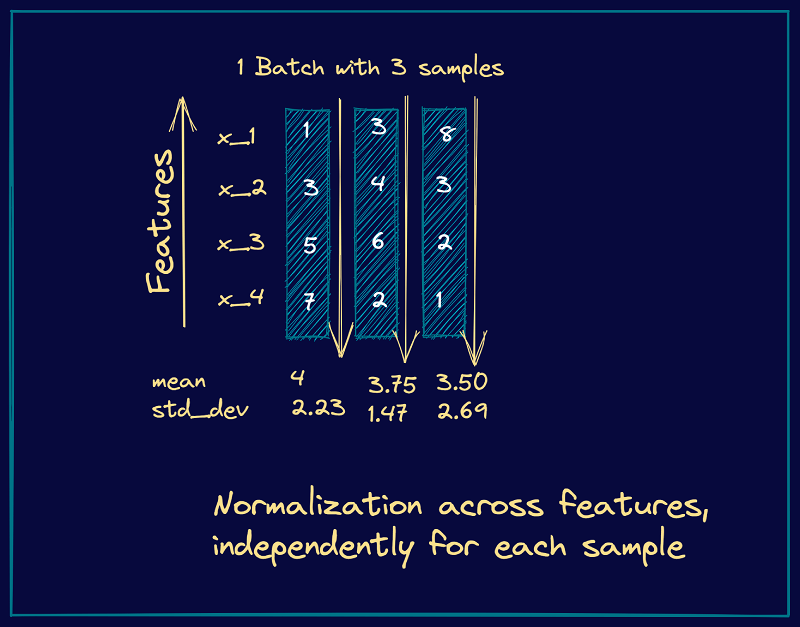

In [ ]:
# Layer Norm Example
batch, embedding_dim = 2, 10
embedding = torch.randn(batch, embedding_dim)
layer_norm = torch.nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)

tensor([[-0.3741,  0.0701, -0.5762,  0.3795,  2.1082,  1.0929,  0.3535, -1.4665,
         -1.1134, -0.4740],
        [-0.8703, -0.1577,  1.5231, -0.7422, -0.3012,  1.3006,  0.5232, -0.3357,
         -1.8367,  0.8970]], grad_fn=<NativeLayerNormBackward0>)

### **Long Short-Term Memory (LSTM)**
As mentioned before, recurrent neural networks have problems associated with vanishing and exploding gradients. This is a common problem in neural network
updates where successive multiplication by the matrix, $\theta_{hh}$, is inherently unstable; it either results in the gradient disappearing during backpropagation, or in it blowing up to large values in an unstable way. This type of instability is the direct result of successive multiplication with the (recurrent) parameter matrix at various time-stamps.

A second problem is that a recurrent neural network has diﬃculty in retaining the information in a long segment of information, because each transition erases some of the information learned in previous steps.

One way of viewing this problem is that a neural network that uses only multiplicative updates is good only at learning over short sequences, and is therefore inherently endowed with good short-term memory but poor long-term memory.

To address this problem, a solution is to change the recurrence equation for the hidden vector with the use of the LSTM with the use of long-term memory. The operations of the LSTM are designed to have ﬁne-grained control over the data written into this long-term memory.


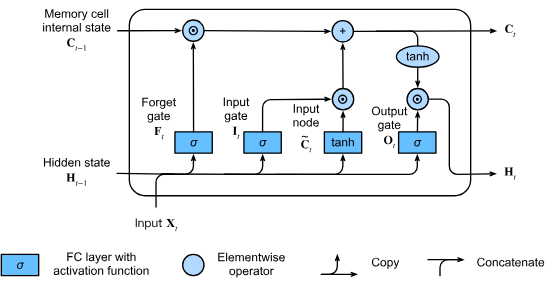

The equations for a LSTM cell begin with an linear mapping of the inputs and previous time step hidden state:

$[z_i, z_f, z_o, z_c]^T = \theta^{(k)} [h_t^{(k-1)}, h_{t-1}^{(k)}]^T$

Then we apply the activation function for the gated signal:

$i = sigmoid(z_i)$

$f = sigmoid(z_f)$

$o = sigmoid(z_o)$

$c = \tanh(z_c)$

where:
- $i \in \Re^{p \times 1} $ is the input gate
- $f \in \Re^{p \times 1} $ is the forget gate
- $o \in \Re^{p \times 1} $ is the output gate
- $c \in \Re^{p \times 1} $ is the cell gate
- $\theta^{(k)} \in \Re^{4p \times 2p} $ is the inputs-to-gate parameter matrix for the $k$th layer.


Then we selectively forget and add to long term memory:

$c_t^{(k)} = f \odot c_{t-1}^{(k)} + i \odot c$

where:
- $c_t = $ long term memory retaining information forgetting and increment updates from previous cell states
- $\odot = $ element wise multiplication


Then selectively leak long term memory to hidden state:

$h_t^{(k)} = o \odot \tanh(c_t^{(k)}) $

where:
- $h_t^{(k)} = $ the hidden state for the $k$th layer


## Classification of Spoken Arabic Digits

The main application of this session is building a classifier that can process unequal sequences of audio data and classify each instance as a digit from 0-9.

### **Data**

Lets download and inspect the dataset for this problem at hand.

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive
import os
from pathlib import Path

# --- download and extract dataset ---
dataset_url = "https://www.timeseriesclassification.com/aeon-toolkit/SpokenArabicDigits.zip"
download_location = "./spoken_arabic"
output_file_name = "spoken_arabic.zip"
download_and_extract_archive(dataset_url, download_location, filename=output_file_name)
spoken_arabic_folder = Path(download_location)


100%|██████████| 82065250/82065250 [00:04<00:00, 18542818.16it/s]


Extracting ./spoken_arabic/spoken_arabic.zip to ./spoken_arabic


In [ ]:
from torch.serialization import load
from sktime.datasets import load_from_tsfile_to_dataframe

dataset_file = spoken_arabic_folder / "SpokenArabicDigits_TRAIN.ts"
data, labels = load_from_tsfile_to_dataframe(dataset_file)


#### ***Dimensionality & Sequence Length***
For time series, or sequence based data, one of the biggest issues is unequal sequence length.

Lets analyze dimensionality of the training data.

Number of input dimensions:  13 ; first entry's sequence length:  38


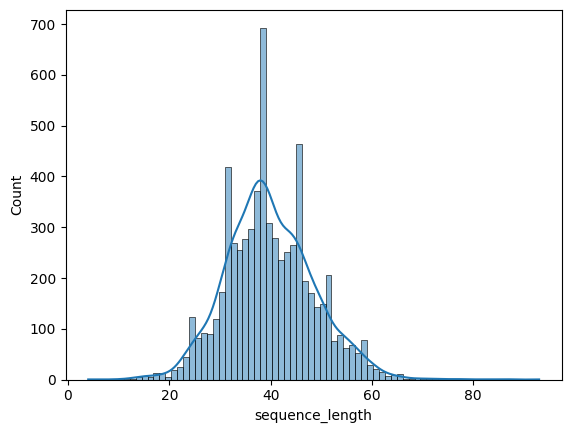

In [ ]:
import seaborn as sns
import pandas as pd

# --- explore the dimensionality ---
first_entry = data.iloc[0]
input_dimensions = len(first_entry)
sequence_length = len(first_entry[0])
print("Number of input dimensions: ", input_dimensions, "; first entry's sequence length: ", sequence_length)

sequence_lengths = []
for idx in range(len(data)):
  sequence_lengths.append(len(data.iloc[idx][0]))

ax = sns.histplot(data=pd.DataFrame(sequence_lengths, columns=['sequence_length']), x="sequence_length", kde=True)

### **Dataset**

We can create a specialized Dataset that loads in and processes the raw data for this problem.

In [ ]:
from typing import Optional, Tuple, Callable
import re
import glob
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sktime.datasets import load_from_tsfile_to_dataframe
# --- internal imports ---

def normalize_per_sample(df):
  for series in df.iterrows():
    for idx, dimension in enumerate(series[1]):
        df.at[series[0], df.columns[idx]] = (dimension - dimension.values.mean()) / dimension.values.std()


class SpokenArabicClassificationLoader(Dataset):

    def __init__(self, root, train: bool, device: Optional[str] = None, normalization: Optional[Callable] = normalize_per_sample):
        self.root = root
        self.train = train
        self.device = device
        self.class_names = None
        self.input_dims = None
        self.output_dims = None
        self.normalizer = None
        self.data_df, self.labels_df = self.load_file(self.train, normalization)

    def load_file(self, train: bool, normalization: Optional[Callable]):
        # --- list all data files in root path ---
        data_paths = glob.glob(os.path.join(self.root, '*'))

        # --- set up the train/test pattern ---
        if train:
            pattern = "Digits_TRAIN"
        else:
            pattern = "Digits_TEST"

        # --- filter the paths by train/test ---
        data_paths = list(filter(lambda x: re.search(pattern, x), data_paths))

        # --- ensure the path is properly formatted ---
        input_paths = [p for p in data_paths if os.path.isfile(p) and p.endswith('.ts')]

        # --- ensure exactly one data file is found ---
        if len(input_paths) != 1:
            raise Exception(f"Expected exactly one data file, got {len(input_paths)} [{input_paths}]")

        # --- load the ts file into a data frame ---
        data, labels = load_from_tsfile_to_dataframe(input_paths[0], True)
        # data, labels = load_from_tsfile_to_dataframe(input_paths[0])

        # --- extract dimensionality ---
        self.input_dims = data.shape[-1]

        # --- normalize the data ---
        if normalization is not None:
            self.normalizer = normalization
            self.normalizer(data)

        # --- create labels series ---
        labels = pd.Series(labels, dtype="category")
        self.class_names = labels.cat.categories
        self.output_dims = len(self.class_names)
        labels_df = pd.DataFrame(labels.cat.codes, dtype=np.int8)

        return data, labels_df

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # --- extract the labels ---
        target = int(self.labels_df.loc[index].values[0])
        # --- extract the data tensor ---
        series = self.data_df.loc[index]
        # --- iterate over all the dimensions ---
        tensors = []
        for dimension in series:
            tensors.append(torch.tensor(dimension.values).view(-1, 1))

        # --- create a final tensor of size (timestamps x dimensions) ---
        inputs = torch.cat(tensors, dim=1).float()
        if self.device is not None:
            return inputs.to(self.device), target

        return inputs, target

    def __len__(self) -> int:
        return len(self.data_df)

    @staticmethod
    def collate_fn_pad(list_pairs_seq_target):
        seqs = [seq for seq, target in list_pairs_seq_target]
        targets = [target for seq, target in list_pairs_seq_target]
        seqs_padded_batched = pad_sequence(seqs)  # will pad at beginning of sequences
        targets_batched = torch.stack(targets)
        assert seqs_padded_batched.shape[1] == len(targets_batched)
        return seqs_padded_batched, targets_batched


### **Model**
For the classifier, we will use an LSTM structure and an output linear layer. We will also use dropout to increase generalization.

In [ ]:

class RnnTimeSeriesClassifier(torch.nn.Module):
    """
    A RNN classifier using a custom  builtin RNN modules.
    """

    def __init__(self, input_dims: int, hidden_dims: int, output_dims: int, layer_norm: bool = False):
        # --- init the parent ---
        super().__init__()

        # --- dimensionality ---
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        # --- recurrent parameters ---
        self.input2gate = torch.nn.Linear(self.input_dims + self.hidden_dims, 4 * self.hidden_dims)
        self.hidden2output = torch.nn.Linear(self.hidden_dims, self.output_dims)

        # --- regularization ---
        self.dropout = torch.nn.Dropout(0.5)

        # --- layer normalization ---
        if layer_norm:
            self.cell_norm = torch.nn.LayerNorm(self.hidden_dims)
            self.gate_norm = torch.nn.LayerNorm(4 * self.hidden_dims)
        else:
            self.cell_norm = torch.nn.Identity()
            self.gate_norm = torch.nn.Identity()

    def forward(self, inputs: torch.Tensor, h=None, c=None) -> torch.Tensor:
        # --- initialize the hidden state ---
        if h is None:
            h = self.initialize_hidden_state(inputs)
            c = self.initialize_hidden_state(inputs)

        # --- compute the hidden state over each timestamp ---
        for x in inputs.unbind(1):
            # --- perform the internal gate computations ---
            state = torch.cat([x, h], dim=1).to(inputs.device)

            # --- transform the gates ---
            gates = self.input2gate(state)
            gates = self.gate_norm(gates)
            i_gate, f_gate, o_gate, c_gate = gates.chunk(4, 1)
            i_gate = i_gate.sigmoid()
            f_gate = f_gate.sigmoid()
            o_gate = o_gate.sigmoid()
            c_gate = c_gate.tanh()
            # --- new cell state ---
            c = f_gate * c + i_gate * c_gate
            c = self.cell_norm(c)
            # --- new hidden state ---
            h = o_gate * F.tanh(c)
        # --- compute the output of the last timestamp ---
        h = self.dropout(h)
        y = self.hidden2output(h)

        # --- compute the probabilities ---
        return F.log_softmax(y, dim=-1)

    def initialize_hidden_state(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.zeros((inputs.shape[0], self.hidden_dims), device=inputs.device)


Utilizing pytorch's built-in we can remove the need for the custom LSTM equations. This increases the efficiency of the network as pytorch as their backend has an optimized implementation.

In [ ]:
class TorchRnnTimeSeriesClassifier(torch.nn.Module):
    """
    A RNN classifier using Pytorch's builtin RNN modules.
    """

    def __init__(self, input_dims, hidden_dims, output_dims):
        # --- init the parent ---
        super().__init__()

        # --- dimensionality ---
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        # --- recurrent parameters ---
        self.rnn = torch.nn.LSTM(self.input_dims, self.hidden_dims, 1, batch_first=True)
        self.h2o = torch.nn.Linear(self.hidden_dims, self.output_dims)

        # --- regularization ---
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, inputs: torch.Tensor, hc=None) -> torch.Tensor:
        # --- compute the rnn predictions ---
        _, (h_out, _) = self.rnn(inputs, hc)
        h = self.dropout(h_out[-1])
        y = self.h2o.forward(h)

        # --- compute the probabilities ---
        return F.log_softmax(y, dim=-1)

### **Trainer**
The trainer is responsible for all dataset handling and training functionality.

In [ ]:
# --- general imports ---
from typing import Callable
import numpy as np
# --- torch imports ---
import torch


class EarlyStopping:
    """
    A class to allow monitoring of model's validation accuracy during training.

    Notes:
        Early stopping during training is one technique to prevent over-fitting of a model.
    """

    def __init__(self,
                 patience: int,
                 checkpoint_path: str,
                 minimum_improvement: float = 0.0,
                 verbose: bool = False,
                 trace_function: Callable = print):
        """
        Args:
            patience: The number of iterations to wait for improvement before early stopping.
            checkpoint_path: The path in which to save the model state.
            minimum_improvement: The minimum change in monitored quantity to qualify as an improvement.
            verbose: Whether to log the improvements for each checkpoint.
            trace_function: Logging function.
        """
        # ---  set the properties ---
        self.patience = patience
        self.checkpoint_path = checkpoint_path
        self.minimum_improvement = minimum_improvement
        self.verbose = verbose
        self.trace_function = trace_function

        # --- initialize the tracking quantities ---
        self.counter = 0
        self.best_score = None
        self.validation_loss_minimum = np.Inf
        self.stop = False

    def __call__(self, model: torch.nn.Module, validation_loss: float):

        if self.best_score is None:
            self.best_score = validation_loss
            self.save_checkpoint(model, validation_loss)
        elif validation_loss > self.best_score - self.minimum_improvement:
            self.counter += 1
            if self.verbose:
                self.trace_function(f"Early Stopping Counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = validation_loss
            self.save_checkpoint(model, validation_loss)
            self.counter = 0

    def save_checkpoint(self, model: torch.nn.Module, validation_loss: float):
        """Saves the Model.

        Args:
            model: The model to save
            validation_loss: The loss of the validation dataset.
        """
        if self.verbose:
            self.trace_function(f"Validation loss: {self.validation_loss_minimum} to {validation_loss}")
        torch.save(model.state_dict(), self.checkpoint_path)
        self.validation_loss_minimum = validation_loss


Now lets create a trainer class. It needs to be able to load in the datasets for training and testing. It will use a training function and testing function.

In [ ]:
class Trainer:

    def __init__(self, input_args):
        # --- parameters ---
        self.input_args = input_args
        self.device = self._acquire_device()
        self.train_loader, self.validation_loader, self.test_loader = self.create_datasets()

        # --- set up the dimensions ---
        self.input_dims = self.train_loader.dataset.input_dims
        self.output_dims = self.train_loader.dataset.output_dims

        # --- set up model paths ---
        self.model_check_point_path = self.input_args.model_path + "/model_checkpoint.pt"
        self.final_model_path = self.input_args.model_path + "/final_model.pt"

        # --- set up early stopping ---
        self.early_stopping = None
        if self.input_args.use_early_stopping:
            self.early_stopping = EarlyStopping(self.input_args.es_patience, self.model_check_point_path)

    def _acquire_device(self):
        if self.input_args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.input_args.gpu) if not self.input_args.use_multi_gpu else self.input_args.devices
            device = torch.device('cuda:{}'.format(self.input_args.gpu))
            print('Use GPU: cuda:{}'.format(self.input_args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def create_datasets(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        # --- create training data ---
        train_data = SpokenArabicClassificationLoader(root=self.input_args.dataset_path, train=True,
                                                      device=self.device,
                                                      normalization=normalize_per_sample if self.input_args.normalize_dataset else None)

        # --- create test data ---
        test_data = SpokenArabicClassificationLoader(root=self.input_args.dataset_path, train=False,
                                                     device=self.device,
                                                     normalization=normalize_per_sample if self.input_args.normalize_dataset else None)

        # --- create train/validation/test datasets ---
        training_size = len(train_data)
        indices = np.arange(training_size)
        # --- shuffle indices in place ---
        for _ in range(1000):
            np.random.shuffle(indices)

        # --- split index ---
        training_split = int(np.floor(training_size * self.input_args.validation_percent))
        train_idx, validation_idx = indices[training_split:], indices[:training_split]

        # --- samplers for batching ---
        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)

        # --- data loaders ---
        train_loader = DataLoader(train_data,
                                  batch_size=self.input_args.batch_size,
                                  sampler=train_sampler,
                                  num_workers=0 if self.input_args.use_gpu else 10)
        validation_loader = DataLoader(train_data,
                                       batch_size=self.input_args.batch_size,
                                       sampler=validation_sampler,
                                       num_workers=0 if self.input_args.use_gpu else 10)
        test_loader = DataLoader(test_data,
                                 batch_size=self.input_args.test_batch_size,
                                 num_workers=0 if self.input_args.use_gpu else 10)

        return train_loader, validation_loader, test_loader

    def train_model(self,
                    model: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,
                    criteria):
        # --- setup tracking losses over epochs ---
        average_train_losses = []
        average_validation_losses = []

        # --- iterate over epochs ---
        for epoch in range(self.input_args.epochs):

            # --- perform training ---
            model.train()
            train_losses = []
            for data, target in self.train_loader:
                # --- clear the gradients ---
                optimizer.zero_grad()
                # --- forward pass ---
                output = model(data)
                # --- compute the loss ---
                loss = criteria(output, target.to(self.device))
                # --- perform backward pass ---
                loss.backward()
                # --- optimization step ---
                optimizer.step()
                # --- update train losses ---
                train_losses.append(loss.detach().item())

            # --- perform validation over the batches ---
            model.eval()
            validation_losses = []
            correct = 0
            number_of_evals = 0
            for data, target in self.validation_loader:
                # --- forward pass ---
                output = model(data)
                # --- compute the loss ---
                loss = criteria(output, target.to(self.device))
                # --- update the validation losses ---
                validation_losses.append(loss.detach().item())
                prediction = torch.exp(output).argmax(-1)
                equate = prediction.eq(target.to(self.device).view_as(prediction)).flatten().detach()
                number_of_evals += len(equate)
                correct += equate.sum().item()

            # --- compute average losses over the batches ---
            train_loss = np.mean(train_losses)
            validation_loss = np.mean(validation_losses)
            accuracy = correct / number_of_evals
            average_train_losses.append(train_loss)
            average_validation_losses.append(validation_loss)

            # --- early stopping ---
            if self.early_stopping is not None:
                self.early_stopping(model, validation_loss)
                if self.early_stopping.stop:
                    print("Stopping training early.")
                    break
            # --- log the training stats ---
            if epoch % self.input_args.log_interval == 0:
                print('Train Epoch: {}\tTrain Loss: {:.6f}\tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
                    epoch, train_loss, validation_loss, accuracy))

            # --- stop training in first epoch if dry run ---
            if self.input_args.dry_run:
                break

        # --- recover the model if using early stopping ---
        if self.early_stopping is not None:
            model.load_state_dict(torch.load(self.early_stopping.checkpoint_path))

        return model, average_train_losses, average_validation_losses

    def model_test(self, model: torch.nn.Module, criteria):
        # --- prep the test metrics ---
        test_losses = []
        correct = 0
        number_of_evals = 0
        model.eval()

        with torch.no_grad():
            # --- test the samples ---
            for data, target in self.test_loader:
                output = model(data)
                test_losses.append(criteria(output, target.to(self.device)).detach().item())
                prediction = output.argmax(dim=-1)
                equate = prediction.eq(target.to(self.device).view_as(prediction)).flatten().detach()
                number_of_evals += len(equate)
                correct += equate.sum().item()

        return np.mean(test_losses), correct / number_of_evals


### **Training Routine**
The training routine combines all the elements designed up until this point. This routine will set up the version of the model, the optimizer, loss function and trainer. It trains and then tests the model.

In [ ]:
# --- training arguments ---
parser = argparse.ArgumentParser(description='PyTorch RNN Time Series Classifier Example')
# --- training generals ---
parser.add_argument('--batch-size', type=int, default=1,
                    help='input batch size for training (default: 1)')
parser.add_argument('--test-batch-size', type=int, default=1,
                    help='input batch size for testing (default: 1)')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='number of epochs to train (default: 500)')
parser.add_argument('--validation_percent', type=float, default=0.1,
                    help='Percentage of training data to use for validation (default: 0.1)')
parser.add_argument('--lr', type=float, default=0.001,
                    help='learning rate (default: 1.0)')

# --- paths ---
parser.add_argument('--dataset_path', type=str,
                    default="./spoken_arabic",
                    help='Path of the dataset')
parser.add_argument('--model_path', type=str, default="./",
                    help='Path of the folder in which to save/load the model')
parser.add_argument('--normalize_dataset', action='store_true', default=False,
                    help='Normalize the dataset along each dimension for each series.')

# --- early stopping ---
parser.add_argument('--use_early_stopping', action='store_false', default=True,
                    help='Disables early stopping.')
parser.add_argument('--es_patience', type=int, default=10,
                    help='The maximum number of epochs to wait for improvements before early stopping.')

# --- model parameters ---
parser.add_argument('--hidden_dims', type=int, default=64,
                    help='Number of hidden dimensions to use for the RNN.')
parser.add_argument('--use_torch_rnn', action='store_true', default=True,
                    help='Whether or not to use the torch built-in RNN modules.')
parser.add_argument('--use_layer_norm', action='store_false', default=True,
                    help='Whether or not to use the layer normalization in the custom lstm.')

# --- device parameters ---
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0', help='device ids of multile gpus')

# --- etc parameters ---
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--log-interval', type=int, default=10,
                    help='how many batches to wait before logging training status')
# --- model saving ---
parser.add_argument('--save-model', action='store_false', default=True,
                    help='For Saving the current Model')
args = parser.parse_args([])

# --- set up gpu ---
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# --- setup the trainer ---
trainer = Trainer(args)

# --- setup the model ---
if args.use_torch_rnn:
    network = TorchRnnTimeSeriesClassifier(trainer.input_dims,
                                           args.hidden_dims,
                                           trainer.output_dims).to(trainer.device)
else:
    network = RnnTimeSeriesClassifier(trainer.input_dims,
                                      args.hidden_dims,
                                      trainer.output_dims,
                                      args.use_layer_norm).to(trainer.device)

# --- put it on the gpu ---
if args.use_multi_gpu and args.use_gpu:
    network = torch.nn.DataParallel(network, device_ids=args.device_ids)

# --- optimizer ---
opt = torch.optim.Adam(network.parameters(), lr=args.lr, amsgrad=True)

# --- loss function ---
loss_function = torch.nn.CrossEntropyLoss()

# --- train the model ---
output_model, train_lss, valid_lss = trainer.train_model(network, opt, loss_function)

# --- test the model ---
test_loss, test_accuracy = trainer.model_test(output_model, loss_function)
print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.3f}%)\n'.format(test_loss, test_accuracy * 100))

# --- save the final model ---
if args.save_model:
    torch.save({"model_state": output_model.state_dict(),
                "training_loss": train_lss,
                "validation_loss": valid_lss,
                "test_loss": test_loss,
                "accuracy": test_accuracy}, trainer.final_model_path)


Use GPU: cuda:0
Train Epoch: 0	Train Loss: 0.826359	Validation Loss: 0.297118	Accuracy: 0.913505
Train Epoch: 10	Train Loss: 0.016994	Validation Loss: 0.050453	Accuracy: 0.995448
Train Epoch: 20	Train Loss: 0.006066	Validation Loss: 0.029777	Accuracy: 0.993930
Stopping training early.

Test set: Average loss: 0.2096, Accuracy: (96.726%)



### **Analysis**

For the analysis we will want to look at the loss plots like normal. In addition we will want to compute common classification metrics which include:

- Accuracy:
  - $m_{acc} = \frac{TP + TN}{TP + TN + FP + FN}$
- Precision:
  - $m_{prec} = \frac{TP}{TP+FP}$
  - Measure what portion of the positive identifications are correct.
- Recall:
  - $m_{recall} = \frac{TP}{TP+FN}$
  - Measure what portion of actual positives are correct

Additionally we can visualize the predictions in a ***confusion matrix***.

See: https://dataaspirant.com/confusion-matrix-sklearn-python/

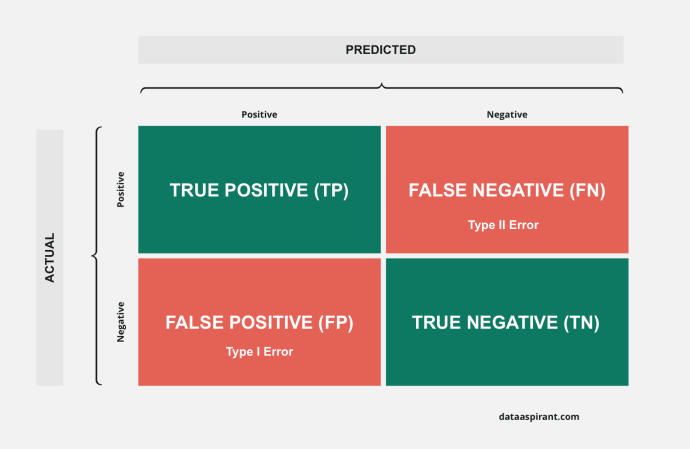

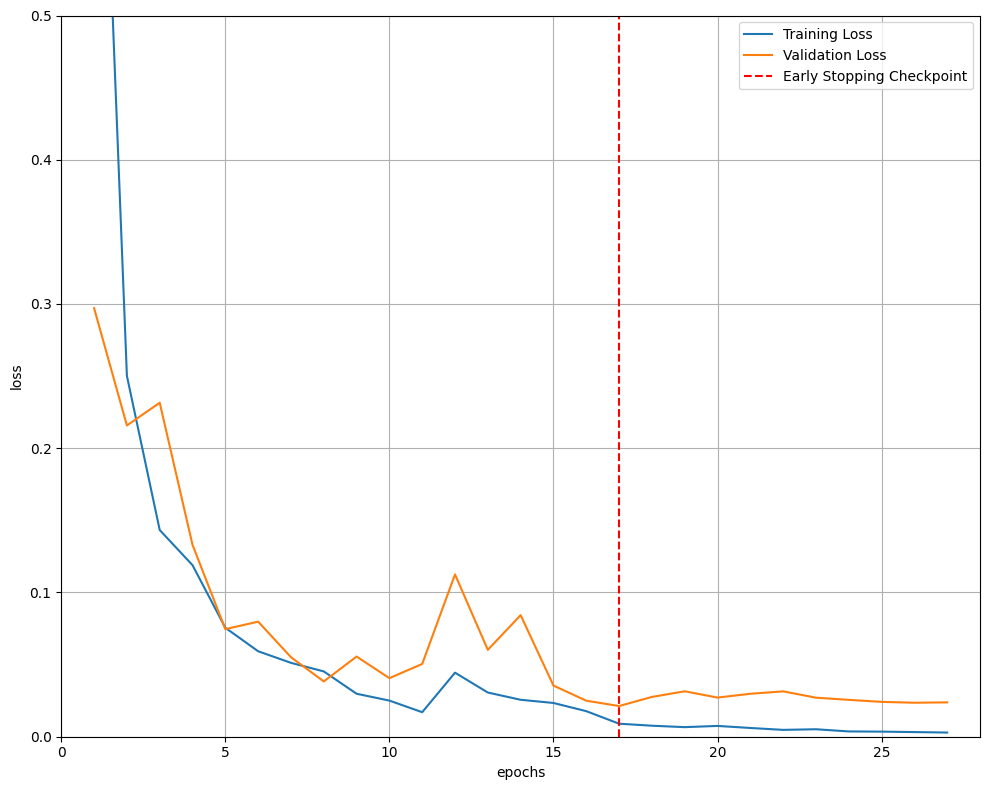

In [ ]:

# --- visualize the loss as the network trained ---
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_lss) + 1), train_lss, label='Training Loss')
plt.plot(range(1, len(valid_lss) + 1), valid_lss, label='Validation Loss')

# --- find position of lowest validation loss ---
model_epoch = valid_lss.index(min(valid_lss))
training_loss = train_lss[model_epoch]
valid_loss = valid_lss[model_epoch]
plt.axvline(model_epoch + 1, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)  # consistent scale
plt.xlim(0, len(train_lss) + 1)  # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(args.model_path + 'loss_plot.png', bbox_inches='tight')


Accuracy:  0.9672578573226929 , Recall:  0.9672706723213196 , Precision:  0.9685237407684326


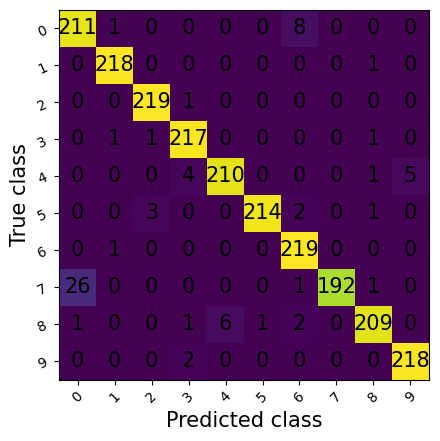

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassAccuracy, MulticlassRecall, MulticlassPrecision
import torchmetrics
# --- prep the test metrics ---
predictions = []
targets = []
output_model.eval()

# --- test the samples ---
for data, target in trainer.test_loader:
    output = output_model(data).detach().cpu()
    prediction = output.argmax(dim=-1)
    predictions.append(prediction)
    targets.append(target)

predictions = torch.tensor(predictions)
targets = torch.tensor(targets)

accuracy_metric = MulticlassAccuracy(10, average='micro')
recall_metric = MulticlassRecall(10)
precision_metric = MulticlassPrecision(10)

accuracy = accuracy_metric(predictions, targets)
recall = recall_metric(predictions, targets)
precision = precision_metric(predictions, targets)

print("Accuracy: ", accuracy.item(), ", Recall: ", recall.item(), ", Precision: ", precision.item())

metric = MulticlassConfusionMatrix(num_classes=10)
metric.update(predictions, targets)
ax = metric.plot()